HW 1-2 PART 1 PCA -----------------------------------------

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
torch.manual_seed(1)
#loading the dataset MNIST
def load_training_data(train_batch_size, test_batch_size):
    trainset = datasets.MNIST('data', train=True, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor()
                              ]))
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

    testset = datasets.MNIST('data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                             ]))
    test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader

In [3]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val

In [4]:
def calc_loss_function(model, loader, loss_fn):
    correct_cnt = 0
    total = 0
    costSum = 0
    costCounter = 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = model(data.view(-1, 784))
            cost = loss_fn(output, target)
            costSum += cost
            costCounter += 1
            for i, outputTensor in enumerate(output):
                if torch.argmax(outputTensor) == target[i]:
                    correct_cnt += 1
                total += 1
    return costSum / costCounter, round(correct_cnt / total, 3)

In [5]:
def train_func(model, num_epochs):
    model.train()
    epoch = 0
    df = pd.DataFrame()
    for epoch in range(num_epochs):
        epoch += 1
        for _, (images, labels) in enumerate(train_loader):
            images, labels = Variable(images), Variable(labels)
            optimizer.zero_grad()
            prediction = model(images.view(-1, 784))
            loss = loss_fn(prediction, labels)
            loss.backward()
            optimizer.step()
        temp_df = pd.DataFrame()
        for name, parameter in model.named_parameters():
            if 'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                temp_df = pd.concat([temp_df, pd.DataFrame(weights).T], axis=1)
        df = pd.concat([df, temp_df], axis=0)
        train_loss, train_acc = calc_loss_function(M, train_loader, loss_fn)
        test_loss, test_acc = calc_loss_function(M, test_loader, loss_fn)
        train_loss_array.append(train_loss)
        test_loss_array.append(test_loss)
        train_acc_array.append(train_acc)
        test_acc_array.append(test_acc)
    return df

In [6]:
train_batch_size = 1000
test_batch_size = 1000
train_loader, test_loader = load_training_data(train_batch_size, test_batch_size)
train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []
max_epochs = 32
all_dfs = []
columns = ["x", "y", "loops"]
loss_fn = nn.CrossEntropyLoss()

for count in range(8):
    print("LOOP: " + str(count))
    M = Model0()
    optimizer = torch.optim.Adam(M.parameters(), lr=0.0004, weight_decay=1e-4)
    model_name1 = "loops: " + str(count)
    temp_df = train_func(M, max_epochs)
    all_dfs.append(temp_df)

all_df = pd.concat(all_dfs, ignore_index=True)
df = all_df
df = np.array(df)
pca = PCA(n_components=2)
new_data = pca.fit_transform(df)
df = pd.DataFrame(new_data, columns=['x', 'y'])
df['Accuracy'] = train_acc_array
df['Loss'] = train_loss_array
final_df = df.iloc[::3, :]

LOOP: 0
LOOP: 1
LOOP: 2
LOOP: 3
LOOP: 4
LOOP: 5
LOOP: 6
LOOP: 7


Text(0.5, 1.0, 'PCA FOR THE WHOLE MODEL')

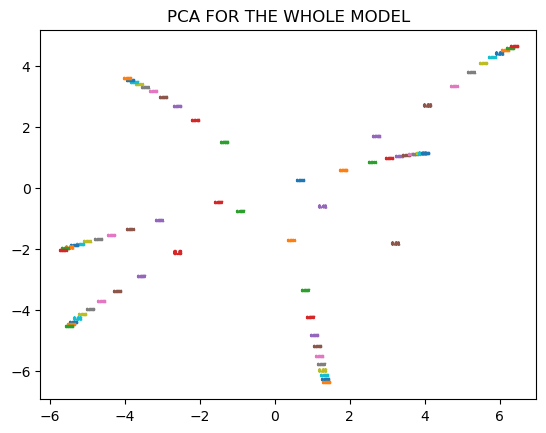

In [7]:
for i in range(66):
    m = list(final_df['Accuracy'])[i]
    plt.scatter(final_df['x'][i * 3], final_df['y'][i * 3], marker=f'${m}$')
plt.title("PCA FOR THE WHOLE MODEL")
#HERE WE PLOT PCA FOR THE WHOLE MODEL

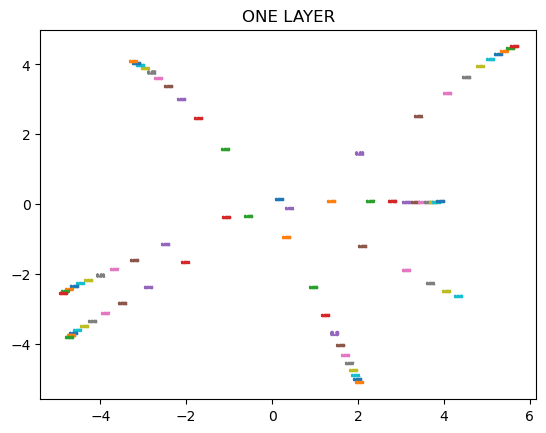

In [8]:
layer_1_data = all_df.iloc[:, :7000]
layer_1_pca = PCA(n_components=2)
layer_1_new_data = layer_1_pca.fit_transform(layer_1_data)
layer_1_df = pd.DataFrame(layer_1_new_data, columns=['x', 'y'])
layer_1_df['Accuracy'] = train_acc_array
layer_1_df['Loss'] = train_loss_array

for i in range(70):
    m = list(layer_1_df['Accuracy'])[i]
    plt.scatter(layer_1_df['x'][i * 3], layer_1_df['y'][i * 3], marker=f'${m}$')

plt.title("ONE LAYER")
plt.show()
#HERE WE DO PCA FOR 1 LAYER

PART 2 GRADIANT NORM

In [9]:
torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)
y = (np.sin(5 * np.pi * x)) / (5 * np.pi * x)
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

/local_scratch/slurm.665682/ipykernel_852949/2228587196.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [10]:
class Model0(nn.Module):
    def __init__(self):
        super(Model0, self).__init__()
        self.fc1 = nn.Linear(1, 190)
        self.fc2 = nn.Linear(190, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
def train_model(model, x, y, max_iteration=10000, convergence_threshold=1.0e-05):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    loss_func = torch.nn.MSELoss()

    iteration_arr, loss_arr, grad_arr = [], [], []
    not_converged = True
    iteration = 0

    while not_converged:
        iteration += 1
        prediction = model(x)
        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        loss.backward()

        grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()])).item()
        grad_arr.append(grad_norm)
        iteration_arr.append(iteration)
        loss_arr.append(loss.item())

        optimizer.step()

        if iteration % 100 == 0:
            print(f'iteration: {iteration}, loss = {loss.item():.4f}, grad_norm = {grad_norm}')

        if iteration > max_iteration:
            print("Max Iterations Reached")
            not_converged = False
        elif iteration > 5 and loss.item() < 0.001:
            if abs(grad_arr[-3] - grad_arr[-2]) < convergence_threshold and abs(grad_arr[-2] - grad_arr[-1]) < convergence_threshold:
                print(f"Convergence reached for loss: {loss.item()}")
                not_converged = False

    return iteration_arr, loss_arr, grad_arr, prediction

torch.manual_seed(1)
model0 = Model0()
total_parameters = sum(p.numel() for p in model0.parameters())
print('Total number of parameters in Model0:', total_parameters)

iteration_arr, loss_arr, grad_arr, prediction = train_model(model0, x, y)

Total number of parameters in Model0: 571
iteration: 100, loss = 0.0586, grad_norm = 0.040222857147455215
iteration: 200, loss = 0.0396, grad_norm = 0.03179505094885826
iteration: 300, loss = 0.0261, grad_norm = 0.023222727701067924
iteration: 400, loss = 0.0169, grad_norm = 0.01734357513487339
iteration: 500, loss = 0.0114, grad_norm = 0.012482398189604282
iteration: 600, loss = 0.0085, grad_norm = 0.008574019186198711
iteration: 700, loss = 0.0070, grad_norm = 0.005912081338465214
iteration: 800, loss = 0.0062, grad_norm = 0.004769917577505112
iteration: 900, loss = 0.0057, grad_norm = 0.00404528109356761
iteration: 1000, loss = 0.0054, grad_norm = 0.003762192092835903
iteration: 1100, loss = 0.0051, grad_norm = 0.0051990896463394165
iteration: 1200, loss = 0.0048, grad_norm = 0.005088740959763527
iteration: 1300, loss = 0.0044, grad_norm = 0.005074725951999426
iteration: 1400, loss = 0.0041, grad_norm = 0.003124042646959424
iteration: 1500, loss = 0.0038, grad_norm = 0.0073801390826

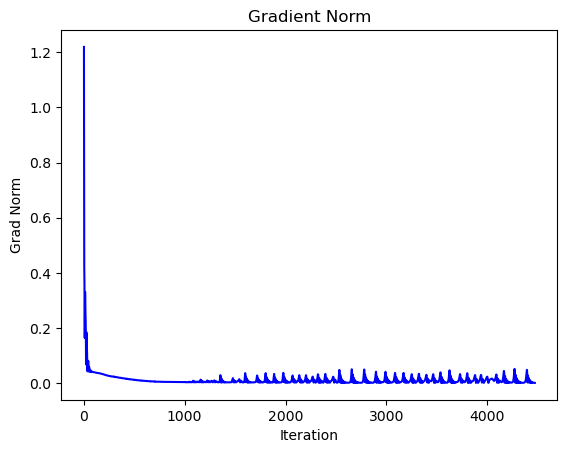

In [12]:
# Plot gradient norm against iterations
plt.plot(iteration_arr, grad_arr, color="blue")
plt.title('Gradient Norm')
plt.xlabel("Iteration")
plt.ylabel("Grad Norm")
plt.show()

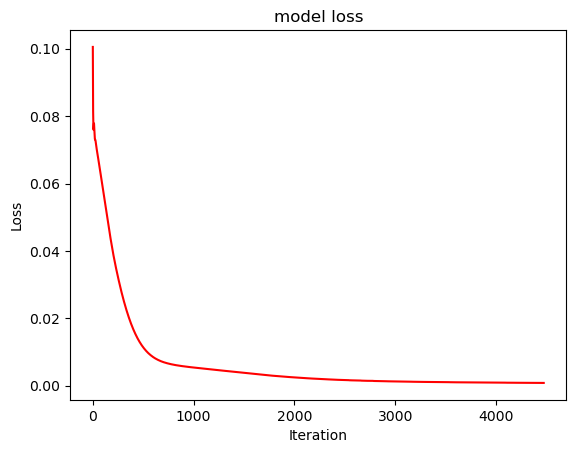

In [13]:
# Plot loss against iterations
plt.plot(iteration_arr, loss_arr, color="red")
plt.title('model loss')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

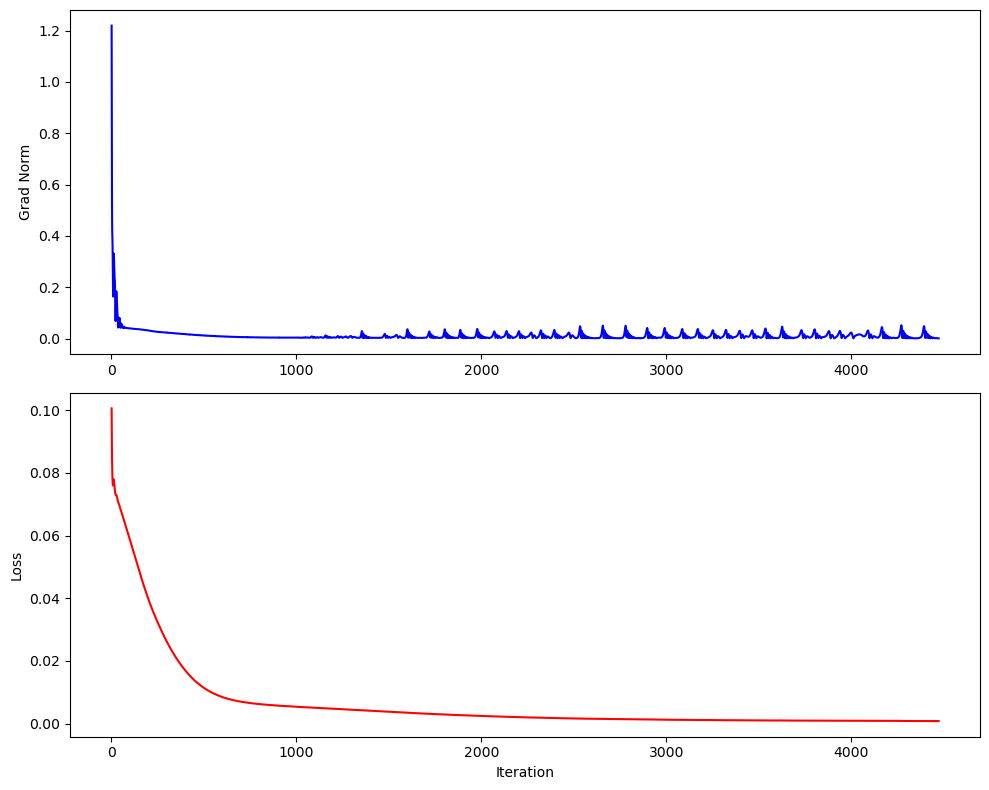

In [14]:
# Plot gradient norm and loss against iterations in one figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(iteration_arr, grad_arr, color="blue", label="Grad Norm")
ax1.set_ylabel("Grad Norm")

ax2.plot(iteration_arr, loss_arr, color="red", label="Loss")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")

plt.tight_layout()
plt.show()

PART 3 MINIMUM GRADIANT

In [15]:
torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)
y = (np.sin(5 * np.pi * x)) / (5 * np.pi * x)
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

/local_scratch/slurm.665682/ipykernel_852949/2228587196.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = nn.Linear(1, 4)
        self.linear_2 = nn.Linear(4, 9)
        self.linear_3 = nn.Linear(9, 12)
        self.linear_4 = nn.Linear(12, 10)
        self.linear_5 = nn.Linear(10, 10)
        self.linear_6 = nn.Linear(10, 10)
        self.linear_7 = nn.Linear(10, 4)
        self.predict = nn.Linear(4, 1)

    def forward(self,x):
        x = nn.functional.leaky_relu(self.linear_1(x))
        x = nn.functional.leaky_relu(self.linear_2(x))
        x = nn.functional.leaky_relu(self.linear_3(x))
        x = nn.functional.leaky_relu(self.linear_4(x))
        x = nn.functional.leaky_relu(self.linear_5(x))
        x = nn.functional.leaky_relu(self.linear_6(x))
        x = nn.functional.leaky_relu(self.linear_7(x))

        x = self.predict(x)
        return x

In [17]:
model = Model()
total_params = sum(p.numel() for p in model.parameters())
print('Total parameters ', total_params)

Total parameters  572


In [18]:
def train_model(model, x, y):
    epoch_size = 4000
    loss_arr = []
    epoch_arr = []
    grad_arr = []
    converged = False
    min_grad = 0
    loss_val=0
    minimal_ratio = 0.0

    for epoch in range(epoch_size):
        if(converged):
            return epoch_arr, loss_arr, y_prediction, grad_arr

        y_prediction = model(x)
        lossm_val = 0.001
        loss = loss_func(y_prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())

        #we calculate the gradient
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5

        grad_arr.append(grad_norm)

        total_params=sum(p.numel() for p in model.parameters())
        if grad_norm < 0.001 or epoch == epoch_size:
            print('the gradient norm has reached a min value')
            predicted_y = model(x)
            lossm=loss_func(predicted_y,y)
            H = torch.zeros((total_params, total_params))

            gradient = torch.autograd.grad(lossm, list(model.parameters()), create_graph=True)
            gradient = torch.cat([e.flatten() for e in gradient]) # flatten
            for i in range(total_params):
                result = torch.autograd.grad(gradient[i], list(model.parameters()), retain_graph=True)
                H[i] = torch.cat([r.flatten() for r in result]) # flatten
            H_eig = torch.linalg.eigvalsh(H, UPLO='U')  # eigenvalues

            positive_count=0
            for i in H_eig.tolist():
                if(i>0):
                    positive_count+=1
            minimal_ratio = positive_count/H.shape[0]
            print(' Minimum value: ',minimal_ratio)
            print(' Loss:  ', lossm.data.detach().numpy())
            print(' the current epoch: ', epoch)
            lossm_val=lossm.data.detach().numpy()
            break


    return lossm_val,minimal_ratio

In [19]:
loss_arr = []
min_ratio_arr = []
for index in range(100):
    print("Training model ", index) #index gives us the model number
    model = Model()
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

    loss_value, min_ratio = train_model(model, x, y)
    loss_arr.append(loss_value)
    min_ratio_arr.append(min_ratio)

Training model  0
the gradient norm has reached a min value
 Minimum value:  0.5384615384615384
 Loss:   0.00041764046
 the current epoch:  904
Training model  1
the gradient norm has reached a min value
 Minimum value:  0.5384615384615384
 Loss:   0.0026393533
 the current epoch:  1081
Training model  2
the gradient norm has reached a min value
 Minimum value:  0.5017482517482518
 Loss:   0.08690248
 the current epoch:  24
Training model  3
the gradient norm has reached a min value
 Minimum value:  0.5244755244755245
 Loss:   0.0027257171
 the current epoch:  1117
Training model  4
the gradient norm has reached a min value
 Minimum value:  0.5017482517482518
 Loss:   0.08689961
 the current epoch:  151
Training model  5
the gradient norm has reached a min value
 Minimum value:  0.5034965034965035
 Loss:   0.086869925
 the current epoch:  98
Training model  6
the gradient norm has reached a min value
 Minimum value:  0.5437062937062938
 Loss:   0.0023828337
 the current epoch:  598
Tra

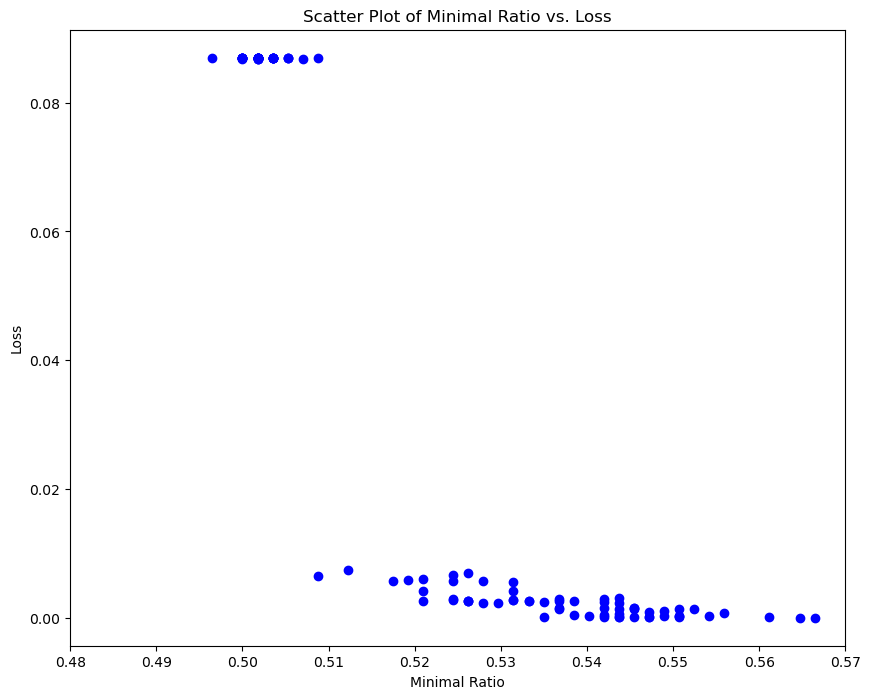

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(min_ratio_arr, loss_arr, color="blue")
plt.xlabel("Minimal Ratio")
plt.ylabel("Loss")
plt.title("Scatter Plot of Minimal Ratio vs. Loss")

# Adjust x-axis and y-axis scales
plt.xlim(0.48, 0.57)  # Replace x_min and x_max with your desired values
 # Replace y_min and y_max with your desired values

plt.show()